In [4]:
import pickle
import numpy as np
import scipy.stats as st
import scanpy as sc
from copy import deepcopy
from distutils.dir_util import copy_tree

with open('/home/jislam/Documents/gits/reproduce_thesis/chapter_04/extra_scripts/src.py') as f:
    exec(f.read())

with open('/home/jislam/Documents/gits/reproduce_thesis/chapter_04/extra_scripts/tcga_src.py') as f:
    exec(f.read())

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 


In [7]:
sns.set(style="whitegrid")
min_optuna=10
hyperparam_epochs=200 #max per trial
hyperparam_trials=100 #number of trials for each model.
n_top_genes=500
augment=1
bsize=128
burn_in=10
patience=5
runs=100
zi=False
main_path="/home/jislam/Documents/gits/reproduce_thesis/chapter_04/analysis/"
filter_by="cancerxrisk"
cancer1="BRCA"
cancer2="COAD"
categories_to_keep = 10 #number of cell types I want to keep in the model sorted by decreasing cell count, can use all but only so much weighted losses can do...
category_labels=[filter_by] # See adata.obs.columns for what categories you can use here. Specify which columns to one-hot-encode and use to inform the models. cell_disease is generated for the interaction.
group_a=["High Risk"]
group_b=["High Risk"]
shared_filter =None
result_folder=f"sim_tcga_{cancer1}_{group_a[0]}_to_{cancer2}_{group_b[0]}_{str(augment)}x"
validation_ratio=0.2 #10% of dataset is kept for validation during training. we do not use a testing set since we're only interested in what it learned not generalizability. however, we do want to stop at a reasonable point
outdir=result_folder.replace(" ", "_")
if not os.path.exists(outdir):
    os.makedirs(outdir)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#rnaseq=pd.read_csv('/home/jislam/Documents/gits/reproduce_thesis/chapter_04/data/tcga_data/EBPlusPlusAdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.tsv',sep="\t")
rnaseq=pd.read_csv('/home/jislam/Documents/gits/reproduce_thesis/chapter_04/data/tcga_data/EB++AdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.xena',sep="\t")
rnaseq.rename(columns={'sample': 'gene_id'}, inplace=True)
#rnaseq = filter_primary_tumors(rnaseq)
rnaseq = filter_smallest_sample(rnaseq)

{'TCGA-OR-A5J1': 'TCGA-OR-A5J1-01', 'TCGA-OR-A5J2': 'TCGA-OR-A5J2-01', 'TCGA-OR-A5J3': 'TCGA-OR-A5J3-01', 'TCGA-OR-A5J5': 'TCGA-OR-A5J5-01', 'TCGA-OR-A5J6': 'TCGA-OR-A5J6-01', 'TCGA-OR-A5J7': 'TCGA-OR-A5J7-01', 'TCGA-OR-A5J8': 'TCGA-OR-A5J8-01', 'TCGA-OR-A5J9': 'TCGA-OR-A5J9-01', 'TCGA-OR-A5JA': 'TCGA-OR-A5JA-01', 'TCGA-OR-A5JB': 'TCGA-OR-A5JB-01', 'TCGA-OR-A5JC': 'TCGA-OR-A5JC-01', 'TCGA-OR-A5JD': 'TCGA-OR-A5JD-01', 'TCGA-OR-A5JE': 'TCGA-OR-A5JE-01', 'TCGA-OR-A5JF': 'TCGA-OR-A5JF-01', 'TCGA-OR-A5JG': 'TCGA-OR-A5JG-01', 'TCGA-OR-A5JI': 'TCGA-OR-A5JI-01', 'TCGA-OR-A5JJ': 'TCGA-OR-A5JJ-01', 'TCGA-OR-A5JK': 'TCGA-OR-A5JK-01', 'TCGA-OR-A5JL': 'TCGA-OR-A5JL-01', 'TCGA-OR-A5JM': 'TCGA-OR-A5JM-01', 'TCGA-OR-A5JO': 'TCGA-OR-A5JO-01', 'TCGA-OR-A5JP': 'TCGA-OR-A5JP-01', 'TCGA-OR-A5JQ': 'TCGA-OR-A5JQ-01', 'TCGA-OR-A5JR': 'TCGA-OR-A5JR-01', 'TCGA-OR-A5JS': 'TCGA-OR-A5JS-01', 'TCGA-OR-A5JT': 'TCGA-OR-A5JT-01', 'TCGA-OR-A5JV': 'TCGA-OR-A5JV-01', 'TCGA-OR-A5JW': 'TCGA-OR-A5JW-01', 'TCGA-OR-A5JX': 'TC

In [9]:
# extract the last two characters of each column name
suffixes = rnaseq.columns.str[-2:]

# get counts of each unique suffix
counts = suffixes.value_counts()
counts

01    9702
06     367
03     173
11      24
02       8
id       1
Name: count, dtype: int64

In [6]:
rnaseq

,gene_id,TCGA-OR-A5J1-01,TCGA-OR-A5J2-01,TCGA-OR-A5J3-01,TCGA-OR-A5J5-01,TCGA-OR-A5J6-01,TCGA-OR-A5J7-01,TCGA-OR-A5J8-01,TCGA-OR-A5J9-01,TCGA-OR-A5JA-01,...,TCGA-CG-4449-01,TCGA-CG-4462-01,TCGA-CG-4465-01,TCGA-CG-4466-01,TCGA-CG-4469-01,TCGA-CG-4472-01,TCGA-CG-4474-01,TCGA-CG-4475-01,TCGA-CG-4476-01,TCGA-CG-4477-01
0,100130426,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100133144,2.09,1.88,1.45,0.00,0.00,1.12,1.29,0.00,2.45,...,2.42,2.74,2.64,3.99,4.40,3.00,4.27,3.71,4.29,4.24
2,100134869,2.30,3.32,2.92,1.35,2.45,2.82,1.72,1.24,2.60,...,1.87,2.12,1.78,2.60,3.66,3.87,3.07,3.65,3.64,3.99
3,10357,7.23,6.36,6.45,5.78,6.09,6.71,6.58,6.31,6.13,...,9.31,8.20,9.43,9.14,10.02,9.32,9.54,8.99,9.48,9.46
4,10431,10.99,10.35,10.04,11.20,10.30,10.87,9.96,10.78,10.25,...,10.23,9.33,10.21,9.38,9.34,10.34,10.17,10.43,9.93,10.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20526,ZYG11A,0.57,5.02,0.67,3.66,3.14,6.43,0.50,1.76,1.04,...,4.45,1.51,1.97,7.91,1.51,2.09,4.18,2.25,0.38,7.77
20527,ZYG11B,9.34,10.19,9.66,9.12,9.64,9.03,9.12,9.84,9.66,...,10.37,10.00,9.67,9.83,9.90,9.82,9.57,9.86,9.73,9.75
20528,ZYX,10.85,11.58,11.38,11.21,9.47,9.74,13.42,11.05,10.92,...,11.44,12.28,11.75,9.94,11.45,11.71,12.06,11.60,11.69,11.29
20529,ZZEF1,10.18,10.89,10.53,10.16,9.64,9.81,10.10,9.97,9.82,...,10.33,11.01,11.24,10.35,10.13,10.77,11.40,10.42,10.90,10.29


In [2]:
sns.set(style="whitegrid")
min_optuna=10
hyperparam_epochs=200 #max per trial
hyperparam_trials=100 #number of trials for each model.
n_top_genes=500
augment=1
bsize=128
burn_in=10
patience=5
runs=100
zi=False
main_path="/home/jislam/Documents/gits/reproduce_thesis/chapter_04/analysis/"
filter_by="cancerxrisk"
cancer1="BRCA"
cancer2="COAD"
categories_to_keep = 10 #number of cell types I want to keep in the model sorted by decreasing cell count, can use all but only so much weighted losses can do...
category_labels=[filter_by] # See adata.obs.columns for what categories you can use here. Specify which columns to one-hot-encode and use to inform the models. cell_disease is generated for the interaction.
group_a=["High Risk"]
group_b=["High Risk"]
shared_filter =None
result_folder=f"sim_tcga_{cancer1}_{group_a[0]}_to_{cancer2}_{group_b[0]}_{str(augment)}x"
validation_ratio=0.2 #10% of dataset is kept for validation during training. we do not use a testing set since we're only interested in what it learned not generalizability. however, we do want to stop at a reasonable point
outdir=result_folder.replace(" ", "_")
if not os.path.exists(outdir):
    os.makedirs(outdir)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#rnaseq=pd.read_csv('/home/jislam/Documents/gits/reproduce_thesis/chapter_04/data/tcga_data/EBPlusPlusAdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.tsv',sep="\t")
rnaseq=pd.read_csv('/home/jislam/Documents/gits/reproduce_thesis/chapter_04/data/tcga_data/EB++AdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.xena',sep="\t")
rnaseq.rename(columns={'sample': 'gene_id'}, inplace=True)
#rnaseq = filter_primary_tumors(rnaseq)
rnaseq = filter_smallest_sample(rnaseq)
clinical =  pd.read_excel('/home/jislam/Documents/gits/reproduce_thesis/chapter_04/data/tcga_data/TCGA-CDR-SupplementalTableS1.xlsx', sheet_name=None)
clinical=clinical['TCGA-CDR'].copy()
adata=build_anndata(rnaseq=rnaseq,clinical=clinical)


adata.obs['ajcc_simplified']=categorize_ajcc_risk(adata.obs['ajcc_pathologic_tumor_stage'])
to_filter=group_by_both_obs(adata,"type",'ajcc_simplified')
to_keep=to_filter[~((to_filter["_High Risk"] < 10) | 
          (to_filter["_Low Risk"]  <10) | 
          (to_filter[["_High Risk", "_Low Risk"]].max(axis=1) / to_filter[["_High Risk", "_Low Risk"]].min(axis=1) > 100))
         ].index

adata = adata[adata.obs['type'].isin(to_keep)].copy()
adata = adata[adata.obs['ajcc_simplified'].isin(['_High Risk','_Low Risk'])].copy()
adata.obs["cancerxrisk"]=adata.obs["type"].astype(str)  + adata.obs["ajcc_simplified"].astype(str)
clear_output(wait=True)
adata.obs['cancerxrisk'].value_counts()

cancerxrisk
BRCA_High Risk    889
HNSC_High Risk    418
COAD_High Risk    364
SKCM_High Risk    342
STAD_High Risk    333
THCA_Low Risk     284
LUAD_Low Risk     272
KIRC_Low Risk     267
KIRC_High Risk    261
LUSC_High Risk    250
LUSC_Low Risk     242
LUAD_High Risk    227
THCA_High Risk    219
BRCA_Low Risk     181
LIHC_High Risk    175
KIRP_Low Risk     171
LIHC_Low Risk     171
PAAD_High Risk    154
ESCA_High Risk    143
READ_High Risk    122
TGCT_Low Risk     101
KIRP_High Risk     87
SKCM_Low Risk      77
MESO_High Risk     74
COAD_Low Risk      74
STAD_Low Risk      56
KICH_High Risk     45
READ_Low Risk      29
HNSC_Low Risk      27
TGCT_High Risk     26
PAAD_Low Risk      21
KICH_Low Risk      20
CHOL_Low Risk      19
ESCA_Low Risk      18
CHOL_High Risk     17
MESO_Low Risk      10
Name: count, dtype: int64

(1253, 16335)


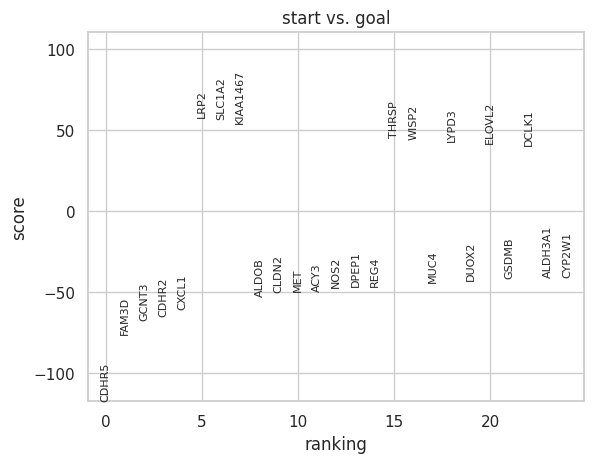

In [3]:


states = adata[(adata.obs[filter_by] == f'{cancer1}_{group_a[0]}') | (adata.obs[filter_by] == f'{cancer2}_{group_b[0]}')].copy()
sc.pp.filter_cells(states, min_genes=100)
sc.pp.filter_genes(states, min_cells=3)
start_state=states[states.obs[filter_by]==f"{cancer1}_{group_a[0]}"].copy()
start_state.X=start_state.X.copy()
goal_state=states[states.obs[filter_by]==f"{cancer2}_{group_b[0]}"].copy()
goal_state.X=goal_state.X.copy()
rnaseq=pd.read_csv('/home/jislam/Documents/gits/reproduce_thesis/chapter_04/data/tcga_data/EBPlusPlusAdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.tsv',sep="\t")
num_samples = 5000

start_state.obs["state"]="start"
goal_state.obs["state"]="goal"
start_state_c=start_state.copy()
goal_state_c=goal_state.copy()
start_indices = np.random.choice(start_state_c.n_obs, size=min(start_state_c.n_obs,num_samples), replace=False)
goal_indices = np.random.choice(goal_state_c.n_obs, size=min(goal_state_c.n_obs,num_samples), replace=False)
combined_adata=merge_adata(start_state[start_indices,:].copy(),goal_state[goal_indices,:].copy())
sc.pp.filter_genes(combined_adata, min_cells=10,inplace=True)
checkpoint=combined_adata.copy()
print(checkpoint.shape)
sc.pp.highly_variable_genes(checkpoint, n_top_genes=n_top_genes)
selection=checkpoint.var.highly_variable.copy()
checkpoint=checkpoint[:, checkpoint.var.highly_variable]
checkpoint=checkpoint.copy()
group_a="start"
group_b="goal"
sc.tl.rank_genes_groups(checkpoint, groupby='state', groups=[group_a], reference=group_b, method='t-test', use_raw=False,rankby_abs=True,key_added="ab")
sc.pl.rank_genes_groups(checkpoint, n_genes=25, sharey=False,key="ab")
basic_dge = extract_rank_genes_groups(checkpoint, key='ab', n_genes=None).drop(columns=['logfoldchange','pval','pval_adj','group'])
basic_dge['absolute_scores']=basic_dge['scores_ab'].abs()


checkpoint=combined_adata.copy()
checkpoint=checkpoint[:, selection]


checkpoint_safe=checkpoint.copy()
checkpoint

filter_by='state'
category_labels=[filter_by]

In [4]:

import scDesign3Py
import os
import multiprocessing
stime=time.time()
# Get the number of available CPU cores
num_cores = os.cpu_count()

# Use all cores except one
cores_to_use = max(num_cores - 1, 1)
#cores_to_use =10

test = scDesign3Py.scDesign3(return_py=True)
test.set_r_random_seed(123)
bpparam = scDesign3Py.get_bpparam(mode="MulticoreParam", show=False)
const_data = test.construct_data(
    anndata=checkpoint,
    default_assay_name="X",
    celltype="state",
    corr_formula="state")#,ncell=5000)
#

marginal = test.fit_marginal(
    data=const_data,
    mu_formula="state",
    sigma_formula="state",
    usebam=False,
    family_use='gaussian',
    n_cores=cores_to_use,
    parallelization="bpmapply",
    bpparam=bpparam
)


copula = test.fit_copula(
    input_data=const_data['dat'],
    marginal_dict=marginal,
    copula="gaussian",
    family_use='gaussian',
    dt=False,
    return_py=True,
    n_cores=cores_to_use,
    parallelization="bpmapply",
    bpparam=bpparam,
)
para = test.extract_para(
    marginal_dict=marginal,
    data=const_data["dat"],
    new_covariate=None#const_data["newCovariate"],
)

print(time.time()-stime)

The R project used is located at /usr/lib/R


R[write to console]: In addition: 


R[write to console]: Warning messages:



R[write to console]: 1: 


R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :


R[write to console]: 
 


R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages



R[write to console]: 2: 


R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :


R[write to console]: 
 


R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages



R[write to console]: 3: 


R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :


R[write to console]: 
 


R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages



R[write to console]: 4: 


R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :


R[write to console]: 
 


R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages



/home/jislam/.local/lib/python3.10/site-packages/scDesign3Py/_core.py:419: UserWarning: There's an unfixed problem in converting the marginal list to OrdDict. Use .rx2 method to get values.
  warnings.warn(
R[write to console]: Convert Residuals to Multivariate Gaussian



R[write to console]: Converting End



R[write to console]: Copula group start starts



R[write to console]: Copula group goal starts



34.379425287246704


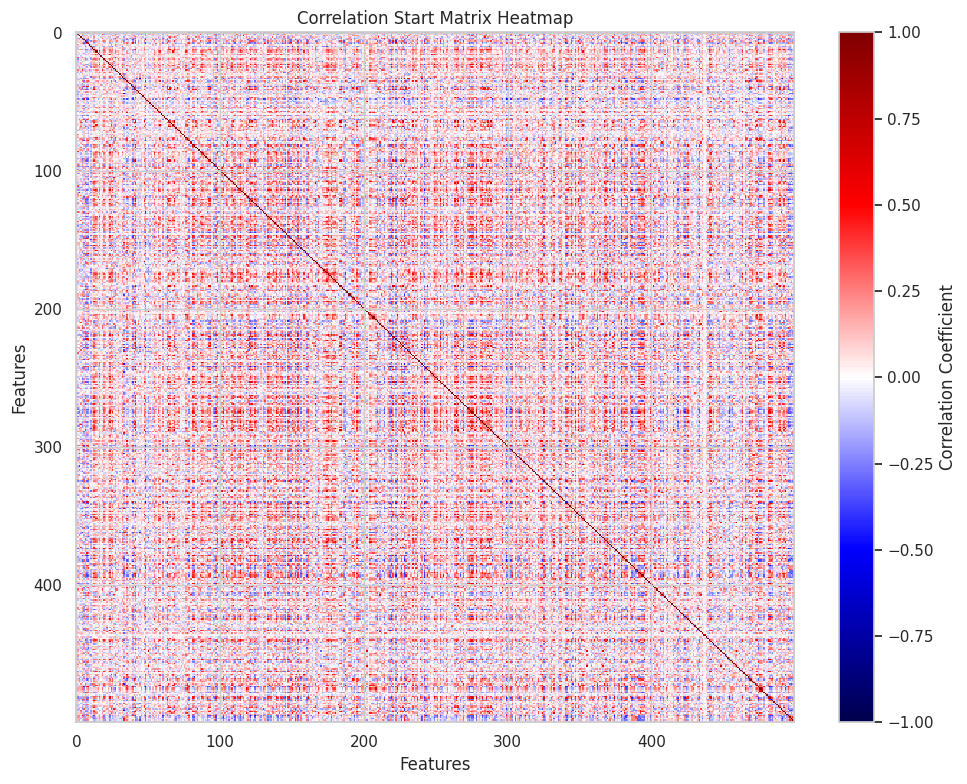

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import TwoSlopeNorm

# Simulating a large 1000x1000 correlation matrix
np.random.seed(42)
corr_matrix = np.random.rand(1000, 1000) * 2 - 1  # Generate values between -1 and 1

# Create a custom colormap with 0 mapped to gray
cmap = plt.get_cmap('seismic')  # Diverging colormap
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)  # Center 0 to gray

# Plot the heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size for large matrices
heatmap = plt.imshow(copula['copula_list']['start'], cmap=cmap, norm=norm, aspect='auto', interpolation='nearest')
plt.colorbar(heatmap, label='Correlation Coefficient')
plt.title("Correlation Start Matrix Heatmap")
plt.xlabel("Features")
plt.ylabel("Features")

plt.tight_layout()
plt.show()

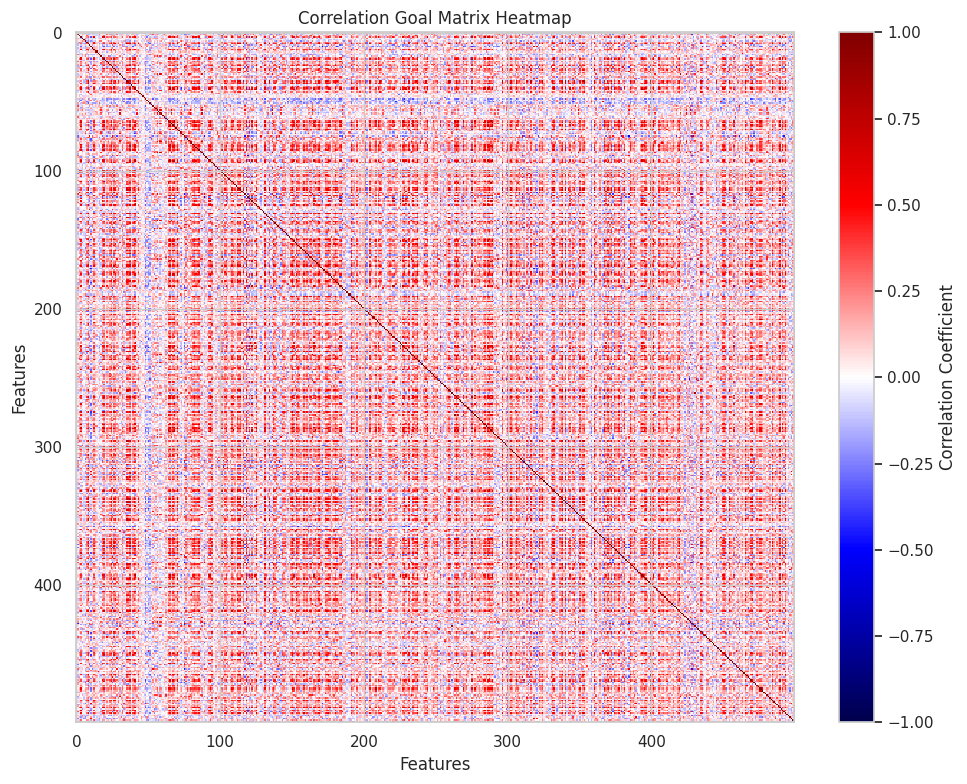

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import TwoSlopeNorm

# Simulating a large 1000x1000 correlation matrix
np.random.seed(42)
corr_matrix = np.random.rand(1000, 1000) * 2 - 1  # Generate values between -1 and 1

# Create a custom colormap with 0 mapped to gray
cmap = plt.get_cmap('seismic')  # Diverging colormap
norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)  # Center 0 to gray

# Plot the heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size for large matrices
heatmap = plt.imshow(copula['copula_list']['goal'], cmap=cmap, norm=norm, aspect='auto', interpolation='nearest')
plt.colorbar(heatmap, label='Correlation Coefficient')
plt.title("Correlation Goal Matrix Heatmap")
plt.xlabel("Features")
plt.ylabel("Features")

plt.tight_layout()
plt.show()

0.05009896249002394


/home/jislam/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


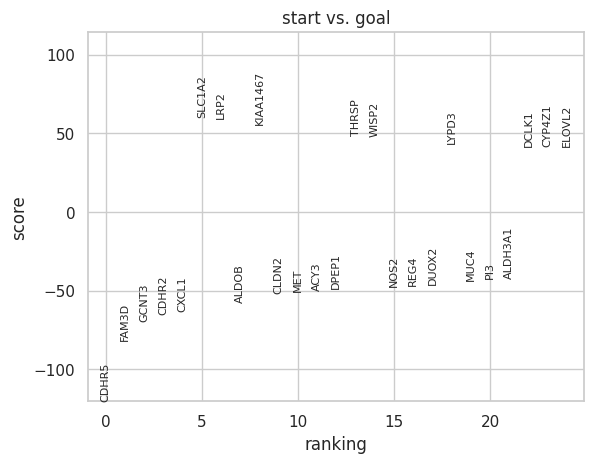

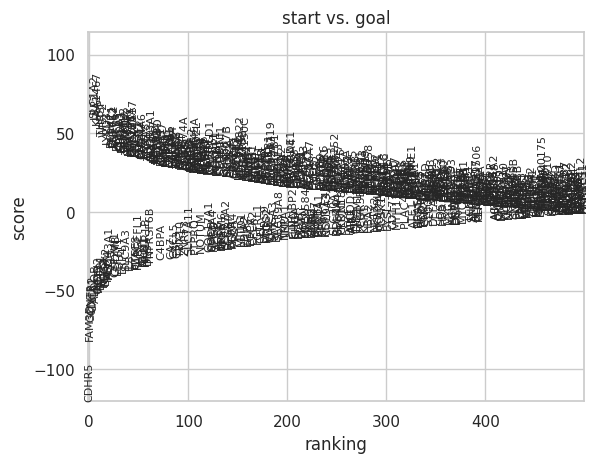

AnnData object with n_obs × n_vars = 1253 × 500
    obs: 'state'
    var: 'mean', 'std'
    uns: 'ab'

In [7]:
import scanpy as sc
import pandas as pd

# List to store each checkpoint
checkpoints = []

# Loop n times to generate checkpoints.
for i in range(augment):
    simu_new = test.simu_new(
        mean_mat=para["mean_mat"],
        sigma_mat=para["sigma_mat"],
        copula_dict=copula["copula_list"],
        input_data=const_data["dat"],
        new_covariate=const_data["newCovariate"],
        important_feature='all',
        filtered_gene=const_data["filtered_gene"],
        n_cores=10,
        parallelization="bpmapply",
        bpparam=bpparam,
        family_use='gaussian'
    )

    # Create an AnnData object for this simulation
    checkpoint = sc.AnnData(
        X=simu_new.to_numpy().copy(),
        obs=const_data["newCovariate"],
        var=pd.DataFrame(index=simu_new.columns)
    )
    # Append the new checkpoint to the list
    checkpoints.append(checkpoint)

if len(checkpoints)>1:
    checkpoint = sc.concat(checkpoints)
else:
    checkpoint=checkpoints[0]
checkpoint.obs_names_make_unique()

clear_output()
sc.pp.scale(checkpoint)
#checkpoint.X = (checkpoint.X ) / (checkpoint.X.max(axis=0))
one_hot_labels, num_categories= gosip.one_hot_encode_combinations(checkpoint.obs, category_labels)
checkpoint.one_hot_labels= one_hot_labels
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


print(np.count_nonzero(simu_new == 0)/simu_new.size)
sc.tl.rank_genes_groups(checkpoint, groupby='state', groups=[group_a], reference=group_b, method='t-test', use_raw=False,rankby_abs=True,key_added="ab")
sc.pl.rank_genes_groups(checkpoint, n_genes=25, sharey=False,key="ab")
sc.pl.rank_genes_groups(checkpoint, n_genes=500, sharey=False,key="ab")
checkpoint

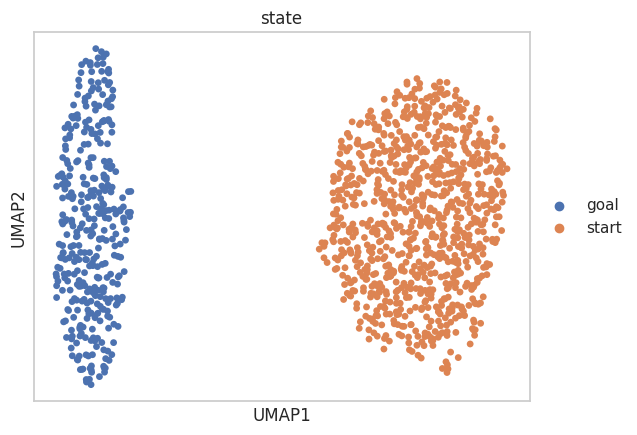

In [8]:

sc.tl.pca(checkpoint,n_comps=10, svd_solver='arpack')
sc.pl.pca_variance_ratio(checkpoint, log=True)
sc.pp.neighbors(checkpoint, n_neighbors=10, n_pcs=10)
sc.tl.leiden(checkpoint, resolution=0.5,n_iterations=2,flavor="igraph")
sc.tl.umap(checkpoint)
clear_output()
sc.pl.umap(checkpoint, color=["state"])

In [9]:
# extract the UMAP array
umap_array = checkpoint.obsm['X_umap']  
n_dims = umap_array.shape[1]

# build a DataFrame with appropriately named columns
umap_df = pd.DataFrame(
    umap_array,
    index=checkpoint.obs_names, 
    columns=[f"UMAP_{i+1}" for i in range(n_dims)]
)
umap_df.index.name='index'
# add the 'state' column from the AnnData.obs
umap_df['state'] = checkpoint.obs['state'].values

# inspect
umap_df.to_csv(f'{main_path}{outdir}/{outdir}_umap.csv')
umap_df

,UMAP_1,UMAP_2,state
index,,,
5448,12.177813,6.346173,start
5301,9.154177,6.947842,start
5951,10.847277,5.646006,start
5246,7.223511,3.556860,start
5841,12.839785,7.166265,start
...,...,...,...
3207,-6.559031,8.268460,goal
8656,-5.901132,8.221967,goal
3251,-7.198632,8.123870,goal


In [10]:

from IPython.display import clear_output
file_path = f"{main_path}{outdir}/result_dictionary.pkl"
category_labels=["state"]
# Check if the file exists
if os.path.exists(file_path):
    with open(file_path, "rb") as f:
        simulation_results = pickle.load(f)
        print("File loaded successfully.")
else:
    simulation_results={}


In [11]:

simulation_results={}

min_layer_size_star=int(checkpoint.shape[1]*2/16)
max_layer_size_star=int(checkpoint.shape[1]*8/16)


min_layer_size_oracle=int(checkpoint.shape[1]*1/16)
max_layer_size_oracle=int(checkpoint.shape[1]*2/16)

min_layer_size_prop=int(checkpoint.shape[1]*2/16)
max_layer_size_prop=int(checkpoint.shape[1]*8/16)

from copy import deepcopy




num_epochs=1000 

spec=False

category_labels=['state']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoints = []

for i in range(augment):
    simu_new = test.simu_new(
        mean_mat=para["mean_mat"],
        sigma_mat=para["sigma_mat"],
        copula_dict=copula["copula_list"],
        input_data=const_data["dat"],
        new_covariate=const_data["newCovariate"],
        important_feature='all',
        filtered_gene=const_data["filtered_gene"],
        n_cores=cores_to_use-1,
        parallelization="bpmapply",
        bpparam=bpparam,
        family_use='gaussian'
    )
    checkpoint = sc.AnnData(
        X=simu_new.to_numpy().copy(),
        obs=const_data["newCovariate"],
        var=pd.DataFrame(index=simu_new.columns)
    )
    checkpoints.append(checkpoint)

if len(checkpoints)>1:
    checkpoint = sc.concat(checkpoints)
else:
    checkpoint=checkpoints[0]
checkpoint.obs_names_make_unique()
one_hot_labels, num_categories= gosip.one_hot_encode_combinations(checkpoint.obs, category_labels)
checkpoint.one_hot_labels= one_hot_labels

group_a="start"
group_b="goal"
checkpoint_backup=deepcopy(checkpoint)
###########################################################################################
###########################################################################################
#### Stargan
###########################################################################################
###########################################################################################         
study = optuna.create_study(storage="sqlite:///"+outdir+"/"+result_folder.replace(" ","_")+"_SIMULATION_stargan_nb.db",
                            direction='minimize',
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.HyperbandPruner(min_resource=min_optuna,
                                                                  max_resource=hyperparam_epochs,
                                                                  reduction_factor=5),
                            study_name=result_folder.replace(" ", "_")+"_stargan_SIMULATION_"+"zero_inflation"+"_num_irrelevant"+"_main.db",
                            load_if_exists=True)
start_time=time.time()
if len(study.get_trials())<hyperparam_trials:
    study.optimize(lambda trial: opt_objective_stargan(trial, checkpoint,num_categories=num_categories,hyperparam_epochs=hyperparam_epochs,validation_ratio=validation_ratio,min_layer_size=min_layer_size_star,max_layer_size=max_layer_size_star, bsize=bsize,burn_in=burn_in,zi=zi), n_trials=hyperparam_trials-len(study.get_trials()))

# Get the best hyperparameters
best_params = study.best_params

stargan_hyperparam = {
    'batch_size': best_params['batch_size'],
    'learning_rate': best_params['learning_rate'],
    'layer_nodes_generator': [
        best_params["gen_layer0"],
        best_params["gen_layer1"],
        best_params["gen_layer2"]
    ],
    'layer_nodes_discriminator': [
        best_params["disc_layer0"],
        best_params["disc_layer1"],
        best_params["disc_layer2"]
    ],
    'critics': 3,
    "dropout_rate":best_params["dropout_rate"]
}

###########################################################################################
###########################################################################################
#### Oracle
###########################################################################################
###########################################################################################


study = optuna.create_study(storage="sqlite:///"+outdir+"/"+result_folder.replace(" ","_")+"_SIMULATION_oracle_nb.db",
                            direction='minimize',
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.HyperbandPruner(min_resource=min_optuna,
                                                                  max_resource=hyperparam_epochs,
                                                                  reduction_factor=5),
                            study_name=result_folder.replace(" ", "_")+"_oracle_SIMULATION_"+"zero_inflation"+"_num_irrelevant"+"_main.db",
                            load_if_exists=True)

start_time=time.time()
if len(study.get_trials())<hyperparam_trials:
    study.optimize(lambda trial: opt_objective_oracle(trial, checkpoint,num_categories=num_categories,hyperparam_epochs=hyperparam_epochs,validation_ratio=validation_ratio,min_layer_size=min_layer_size_oracle,max_layer_size=max_layer_size_oracle, bsize=bsize,burn_in=burn_in), n_trials=hyperparam_trials-len(study.get_trials()))
print(time.time()-start_time)
# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)
oracle_hyperparam = {'batch_size': best_params['batch_size'],
    'learning_rate': best_params['learning_rate'],
    'layer_nodes': [
        best_params["disc_layer0"],
        best_params["disc_layer1"],
        best_params["disc_layer2"]
    ],
    'dropout_rate_d': best_params['disc_dropout_rate']
}


###########################################################################################
###########################################################################################
#### Propagator
###########################################################################################
###########################################################################################

study = optuna.create_study(storage="sqlite:///"+outdir+"/"+result_folder.replace(" ","_")+"_SIMULATION_propagator_nb.db",
                            direction='minimize',
                            sampler=optuna.samplers.TPESampler(),
                            pruner=optuna.pruners.HyperbandPruner(min_resource=min_optuna,
                                                                  max_resource=hyperparam_epochs,
                                                                  reduction_factor=5),
                            study_name=result_folder.replace(" ", "_")+"_propagator_SIMULATION_"+"zero_inflation"+"_num_irrelevant"+"_main.db",
                            load_if_exists=True)

start_time=time.time()
if len(study.get_trials())<hyperparam_trials:
    study.optimize(lambda trial: opt_objective_propagator(trial, checkpoint,num_categories=num_categories,hyperparam_epochs=hyperparam_epochs,validation_ratio=validation_ratio,min_layer_size=min_layer_size_prop,max_layer_size=max_layer_size_prop, bsize=bsize,burn_in=burn_in,zi=zi), n_trials=hyperparam_trials-len(study.get_trials()))
print(time.time()-start_time)
# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)
propagator_hyperparam = {
    'batch_size': best_params['batch_size'],
    'learning_rate': best_params['learning_rate'],
    'layer_nodes_generator': [
        best_params["gen_layer0"],
        best_params["gen_layer1"],
        best_params["gen_layer2"]
    ],
    'dropout_rate_g': best_params['gen_dropout_rate'],
    'latent_dim':best_params['latent'],
    'beta':float(best_params['beta']) 
}

shared_filter = None
filter_criteria_start = ["start"]
filter_criteria_goal  = ["goal"]

checkpoint=deepcopy(checkpoint_backup)


[I 2025-05-27 09:15:17,444] Trial 99 finished with value: -4.250756488582952 and parameters: {'batch_size': 128, 'learning_rate': 0.0009245057299786855, 'gen_layer0': 229, 'gen_layer1': 223, 'gen_layer2': 219, 'gen_dropout_rate': 0.0029983335632783295, 'latent': 11, 'beta': 1}. Best is trial 7 with value: -4.2652630069391515.


265.3331506252289
Best hyperparameters: {'batch_size': 128, 'learning_rate': 0.000656677166856645, 'gen_layer0': 206, 'gen_layer1': 119, 'gen_layer2': 233, 'gen_dropout_rate': 0.008095195476373145, 'latent': 9, 'beta': 1}


In [12]:
oracle_hyperparam

{'batch_size': 128,
 'learning_rate': 0.0009880333990953509,
 'layer_nodes': [34, 50, 59],
 'dropout_rate_d': 0.0640369749674298}

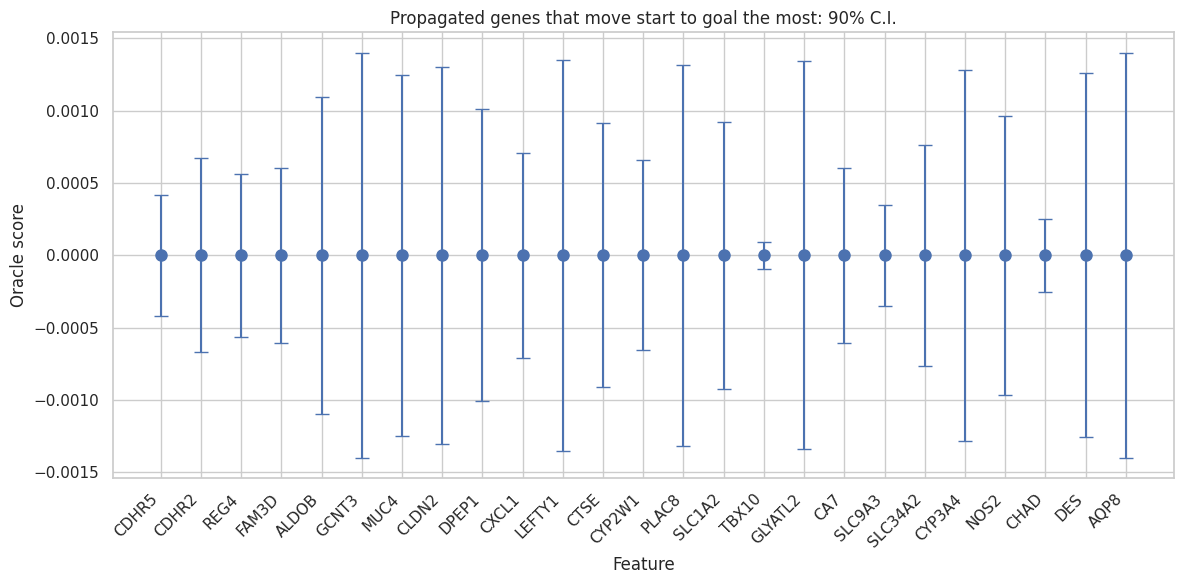

In [13]:

#################################################
###Refit models with new zero-inflation
#################################################
loss_weights=[1,1,10,10]
checkpoint=deepcopy(checkpoint_backup)
#train_adata,val_adata=  split_and_standardize_adata(checkpoint,validation_ratio)
train_adata,val_adata=  split_and_maxabs_scale_adata(checkpoint,validation_ratio)
train_dataloader = gosip.prepare_data(train_adata,num_categories,batch_size=stargan_hyperparam["batch_size"])
val_dataloader = gosip.prepare_data(val_adata,num_categories,batch_size=stargan_hyperparam["batch_size"])
stargan = gosip.StarGAN(input_dim=checkpoint.shape[1],
                 num_domains=[checkpoint.one_hot_labels.shape[1]],
                 device = device,
                 learning_rate = stargan_hyperparam['learning_rate'],
                 layer_g = stargan_hyperparam['layer_nodes_generator'],
                 layer_d = stargan_hyperparam['layer_nodes_discriminator'],
                 critics = stargan_hyperparam['critics'],
                 lambda_adv=loss_weights[0],
                 lambda_cls=loss_weights[1],
                 lambda_rec=loss_weights[2],
                 #lambda_iden=loss_weights[3],
                 dropout_rate=stargan_hyperparam["dropout_rate"],zi=zi)
stargan.train( dataloader=train_dataloader,val_loader=val_dataloader, num_epochs=num_epochs,patience=patience,burn_in=burn_in,verbose=True)
stargan.G.eval()
stargan.D.eval()
torch.cuda.empty_cache()
checkpoint=deepcopy(checkpoint_backup)

train_dataloader = gosip.prepare_data(train_adata,num_categories,batch_size=oracle_hyperparam["batch_size"])
val_dataloader = gosip.prepare_data(val_adata,num_categories,batch_size=oracle_hyperparam["batch_size"])
oracle = gosip.Oracle(input_dim=checkpoint.shape[1],
         num_domains=num_categories,
         device = device,
         learning_rate = oracle_hyperparam['learning_rate'],
         layer_d = oracle_hyperparam['layer_nodes'],
         drpt_d = oracle_hyperparam['dropout_rate_d'])

oracle.train(dataloader=train_dataloader, val_loader=val_dataloader, num_epochs=num_epochs,patience=patience,burn_in=burn_in, verbose=True,optuna_run=False)
oracle.D.eval()
torch.cuda.empty_cache()
checkpoint=deepcopy(checkpoint_backup)

train_dataloader = gosip.prepare_data(train_adata,num_categories,batch_size=propagator_hyperparam["batch_size"])
val_dataloader = gosip.prepare_data(val_adata,num_categories,batch_size=propagator_hyperparam["batch_size"])
propagator = gosip.Propagator(input_dim=train_adata.shape[1],
                 num_domains=num_categories,
                 device = device,
                 learning_rate = propagator_hyperparam['learning_rate'],
                 layer_g = propagator_hyperparam['layer_nodes_generator'],
                 drpt_g = propagator_hyperparam['dropout_rate_g'],
                 latent_dim=propagator_hyperparam['latent_dim'],zi=zi)
loss_fn =gosip.BtcvaeLoss(n_data=train_adata.shape[0],beta=propagator_hyperparam['beta'],zi=zi)#
#loss_fn = gosip.BetaVaeLoss(beta=propagator_hyperparam['beta'])
propagator.train(dataloader=train_dataloader, val_loader=val_dataloader,
                 num_epochs=num_epochs,patience=patience,burn_in=burn_in, verbose=True,optuna_run=False,
                 loss_fn=loss_fn)



propagator.G.eval()



# 1. Concatenate the AnnData objects (this aligns var‐axes, etc.)
processed_checkpoint = ad.concat(
    [train_adata, val_adata],
    join='inner',            # only keep genes present in both
    label='split',           # name of the new obs column
    keys=['train', 'val'],   # values in combined_adata.obs['split']
    fill_value=0
)

# 2. Stitch the one_hot_labels together
combined_labels = pd.concat(
    [train_adata.one_hot_labels, val_adata.one_hot_labels],
    axis=0
)

# 3. Re‐order them to match the new obs order, then attach back
combined_labels = combined_labels.reindex(processed_checkpoint.obs_names)
processed_checkpoint.one_hot_labels = combined_labels.copy()
simulation_results={}
for run in range(runs):
    if len(simulation_results)==runs:
        break
    substring_to_save= "run_"+str(run)
    if substring_to_save not in simulation_results:

        torch.cuda.empty_cache()
        #sc.tl.rank_genes_groups(checkpoint, groupby='state', groups=[group_a], reference=group_b, method='t-test', use_raw=False,rankby_abs=True,key_added="ab")
        #sc.pl.rank_genes_groups(checkpoint, n_genes=25, sharey=False,key="ab")
        checkpoint=deepcopy(checkpoint_backup)
        perturbation_metrics,accuracy,result_path=gosip.full_report(adata=processed_checkpoint,
                                                  stargan=stargan,
                                                  oracle=oracle,
                                                  propagator=propagator,
                                                  shared_filter=None,
                                                  filter_criteria_start=filter_criteria_start,
                                                  filter_criteria_goal=filter_criteria_goal,
                                                  main_path=main_path,outdir=outdir,top_n=25,percentile=0,
                                                  umap=False,oracle_performance=True,alpha=0.5,
                                                  num_categories=num_categories,
                                                  category_labels=category_labels,
                                                  device = device,apply_fdr=False)#,network_fdr_pval_threshold=0.1)
    
        dst_dir = os.path.dirname(result_path[:-1]) + "/" + substring_to_save
        os.makedirs(dst_dir, exist_ok=True)
        
        copy_tree(result_path, dst_dir)
        simulation_results[substring_to_save]=perturbation_metrics
        simulation_results[substring_to_save]['sample_size']=checkpoint.shape[0]
        with open(f"{main_path}{outdir}/result_dictionary.pkl", "wb") as f:
            pickle.dump(simulation_results, f) 

    clear_output(wait=True)



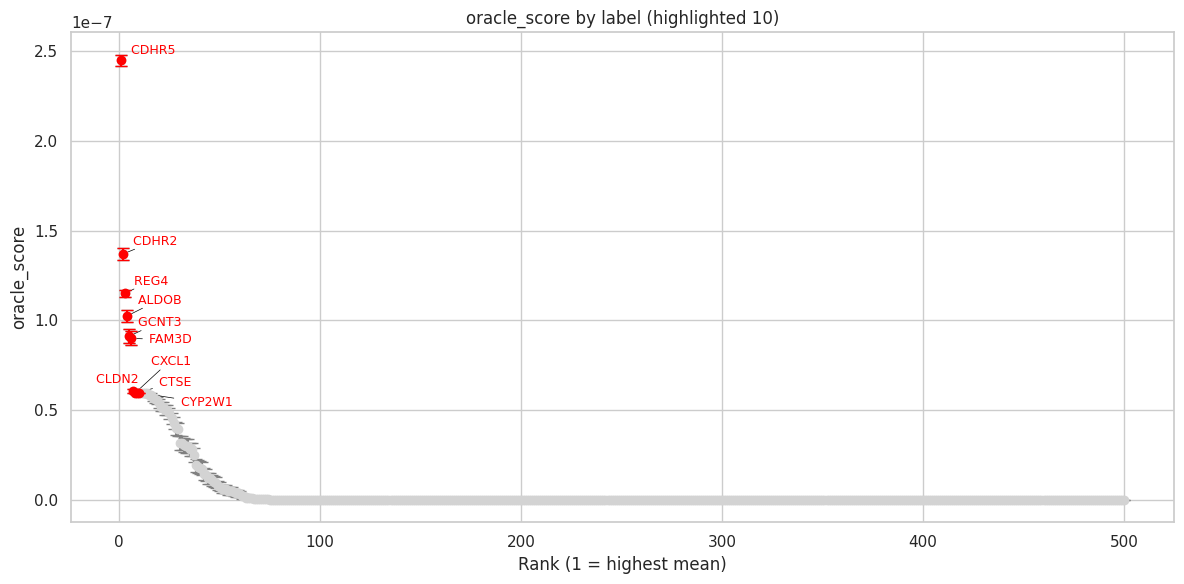

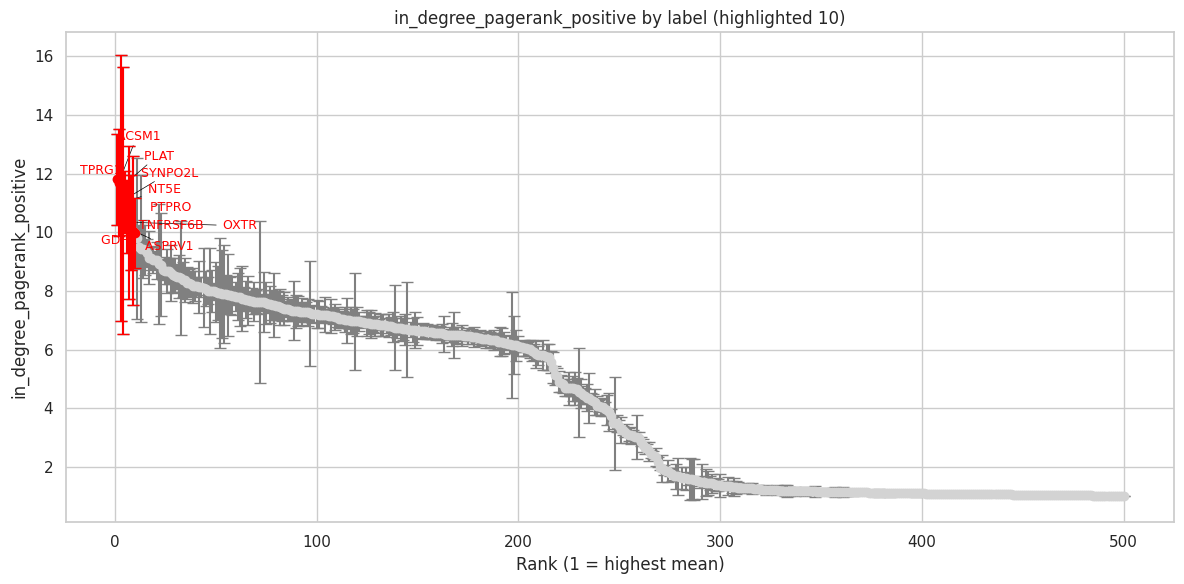

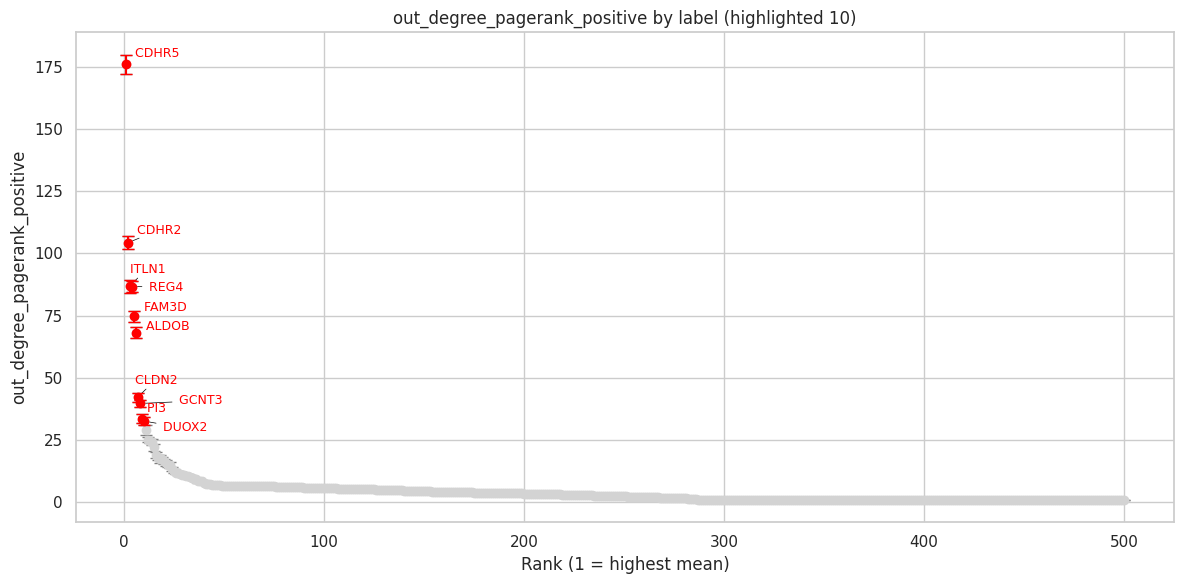

(              mean        ci
 label                       
 CDHR5   176.049637  3.821878
 CDHR2   104.290242  2.550684
 ITLN1    86.923390  2.623351
 REG4     86.730840  2.152483
 FAM3D    74.865580  2.208046
 ...            ...       ...
 SYT1      1.001294  0.000950
 ATE1      1.001116  0.000717
 DGAT2     1.001075  0.000683
 CHGB      1.000996  0.000702
 CNKSR3    1.000914  0.000615
 
 [500 rows x 2 columns],
              mean        ci
 label                      
 CDHR5  176.049637  3.821878
 CDHR2  104.290242  2.550684
 ITLN1   86.923390  2.623351
 REG4    86.730840  2.152483
 FAM3D   74.865580  2.208046
 ALDOB   68.196196  2.099127
 CLDN2   42.322003  1.776650
 GCNT3   39.750615  1.313227
 PI3     33.715725  1.631446
 DUOX2   32.709239  1.578013)

In [14]:

# Call the function
data_frames_to_merge = []
result_names=[]
run_names=simulation_results.keys()
organized_results={}
for run in run_names:
    #print(run)
    temp_df=simulation_results[run].copy()
    direction=True
    temp_df['run']=run
    data_frames_to_merge.append(temp_df)    
organized_results=pd.concat(data_frames_to_merge)
#organized_results[100]=organized_results[100][organized_results[100]['oracle_score']>=0]
#bigger rank is better       

plot_sorted_selected_labels(organized_results, value_col='oracle_score', group_col='label')
plot_sorted_selected_labels(organized_results, value_col='in_degree_pagerank_positive', group_col='label')
plot_sorted_selected_labels(organized_results, value_col='out_degree_pagerank_positive', group_col='label')


In [15]:
stargan_hyperparam
propagator_hyperparam
oracle_hyperparam

{'batch_size': 128,
 'learning_rate': 0.0009880333990953509,
 'layer_nodes': [34, 50, 59],
 'dropout_rate_d': 0.0640369749674298}